In [1]:
from data_utils import load_data, notnan_indices, downsample_signal, moving_average

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import csaps

In [167]:
data_dir = "./data"
virgo_file = "VIRGO_Level1.txt"
results_dir = os.path.join(data_dir, "analysis")

data = load_data(os.path.join(data_dir, virgo_file))

t = data["timestamp"]  # Time in mission days
# t = data["timestamp"].apply(mission_day_to_year)  # Uncomment for time measured in years
pmo_a = data["pmo6v_a"]
pmo_b = data["pmo6v_b"]
temp = data["temperature"]
data.sample(15, random_state=2)

,timestamp,pmo6v_a,pmo6v_b,temperature
916133,707.2037,1364.124,NaN,27.612
4540366,3224.0322,1360.755,NaN,29.833
1184820,893.7919,1363.791,NaN,26.496
1652927,1218.8662,1363.623,NaN,26.422
6541184,4613.4893,NaN,NaN,29.463
6169960,4355.6948,1360.001,NaN,31.748
9447604,6631.8364,1359.868,NaN,29.349
10494042,7358.5293,1359.368,NaN,29.713
11214199,7858.6382,1358.931,NaN,27.109
7101944,5002.9058,1359.604,NaN,28.829


In [168]:
data_nn = data[["timestamp", "pmo6v_a", "pmo6v_b"]].dropna()
t_nn = data_nn["timestamp"]
x_a_nn = data_nn["pmo6v_a"]
x_b_nn = data_nn["pmo6v_b"]
ratio_a_b = x_a_nn/x_b_nn

plt.figure(5, figsize=(16, 8))
#plt.plot(t_nn, ratio_a_b, t_nn, np.exp(a*t_nn+b))
plt.plot(t_nn, np.log(ratio_a_b-0.995), t_nn, a*t_nn+b)
plt.savefig(os.path.join(results_dir, "ratio_a_b_raw.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.show()

ValueError: operands could not be broadcast together with shapes (21524,) (10,) 

<Figure size 1152x576 with 0 Axes>

In [4]:
def exponential_decay(t, a, b):
    return a + np.exp(b*(t))

In [ ]:
X= np.array(t_nn).reshape(-1,1)
logY = np.log(np.array(ratio_a_b)-0.995)

In [ ]:
plt.plot(X, logY)

In [7]:
reg = LinearRegression().fit(X, logY)

In [8]:
reg.coef_

array([-0.00037167])

In [9]:
reg.intercept_

-5.31379277331559

In [10]:
a = reg.coef_[0]
b = reg.intercept_

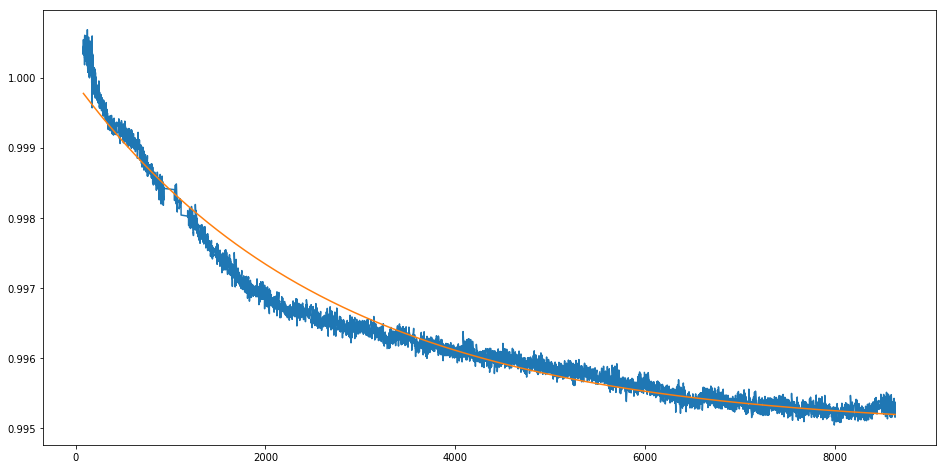

In [11]:
plt.figure(5, figsize=(16, 8))
plt.plot(t_nn, ratio_a_b, t_nn, np.exp(a*t_nn + b)+0.995)


In [5]:
from sklearn.svm import SVR

In [169]:
data = np.stack((t_nn, ratio_a_b)).T
data = data[::100]
data.shape

(216, 2)

In [170]:
y= data[:,1]
X = data[:,0].T.reshape(-1,1)

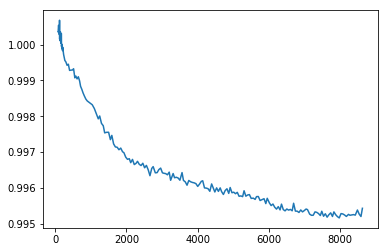

In [8]:
plt.plot(X, y)

In [9]:
cost_param = [10**i for i in range(-2,0)]
epsilon_param = [10**i for i in range(-2, 0)]

param_grid = [
    {
        'C' : cost_param,
        'epsilon' : epsilon_param,
    },
]

In [10]:
grid = GridSearchCV(SVR(kernel='rbf', 
                        gamma='scale'),
                    cv=10, 
                    n_jobs=-1, 
                    param_grid=param_grid)

In [11]:
start_time = time.time()
grid.fit(X, y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.1146769523620605 seconds ---


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [12]:
clf = SVR(C=1e-3, gamma='auto', epsilon=1e-20, kernel='rbf')
clf.fit(X, y)

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=1e-20, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [13]:
clf.get_params()

{'C': 0.001,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 1e-20,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

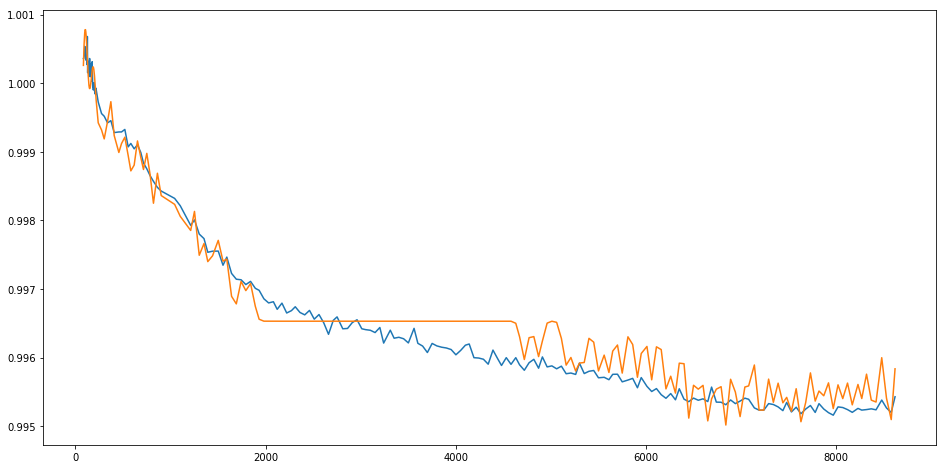

In [154]:
plt.figure(5, figsize=(16, 8))
plt.plot(X, y, X, grid.predict(X.reshape(-1,1)))

In [110]:
sp = csaps.UnivariateCubicSmoothingSpline(X.ravel(), y, smooth=1e-10) 

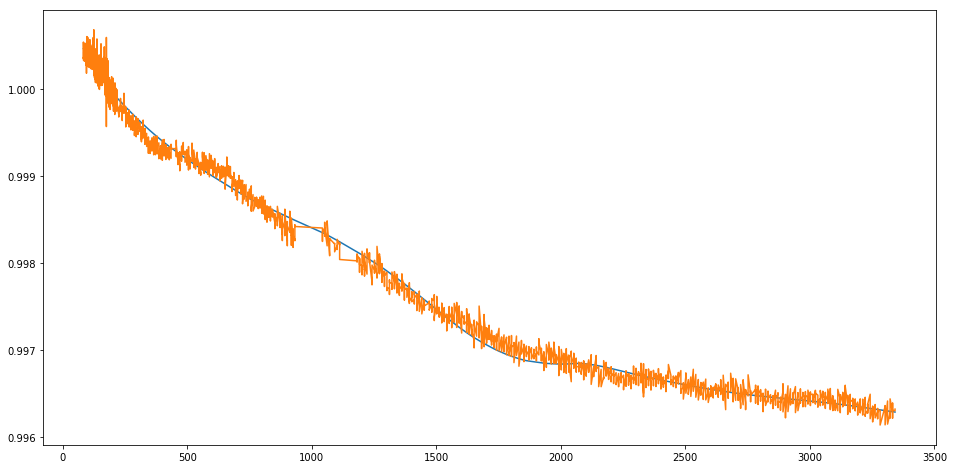

In [111]:
plt.figure(5, figsize=(16, 8))
plt.plot(X.ravel(), sp(X.ravel()), X.ravel(), y)

In [68]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared

In [95]:
kernel = 10*(WhiteKernel() * RBF() + RationalQuadratic() + ExpSineSquared())

In [96]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, y)

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.73690285e-03,  1.39750843e+02, -0.00000000e+00,  2.70022359e-03,
       -6.32436173e-03, -1.76264235e-02,  1.39167453e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 117, 'nit': 30, 'warnflag': 2}
  ConvergenceWarning)


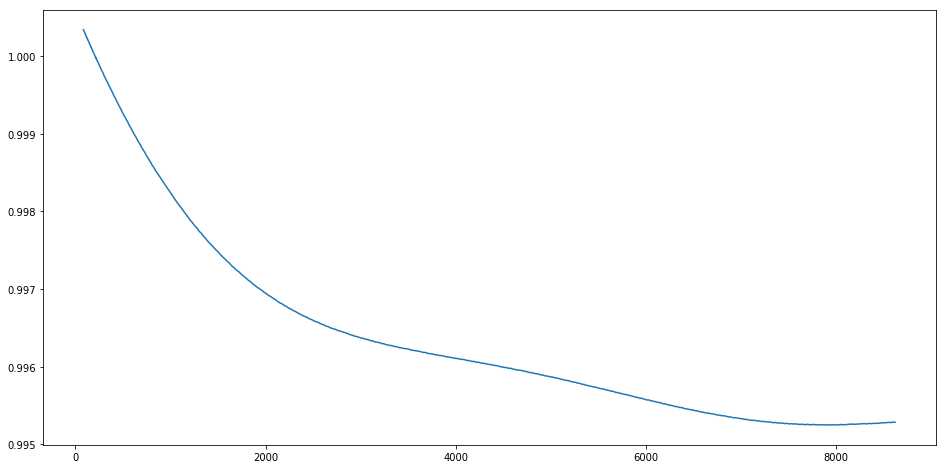

In [97]:
plt.figure(5, figsize=(16, 8))
plt.plot(X, gpr.predict(X))

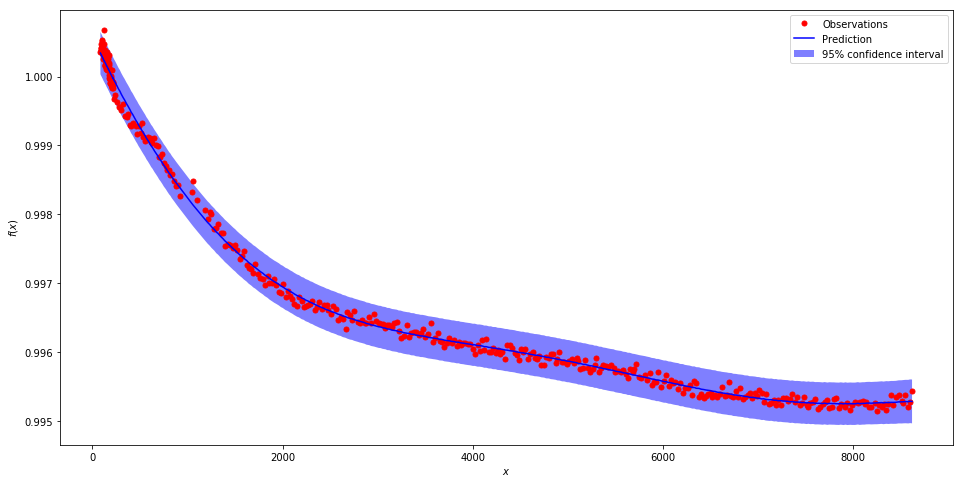

In [102]:
y_pred, sigma = gpr.predict(X, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(5, figsize=(16, 8))
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(X, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([X, X[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
# plt.ylim(0.995, 1)
#plt.xlim(2000, 4000)
plt.legend(loc='upper right')

In [80]:
from scipy.interpolate import UnivariateSpline

In [81]:
spline_1 = UnivariateSpline(X, y, k=3, s=0.2*1e-5)

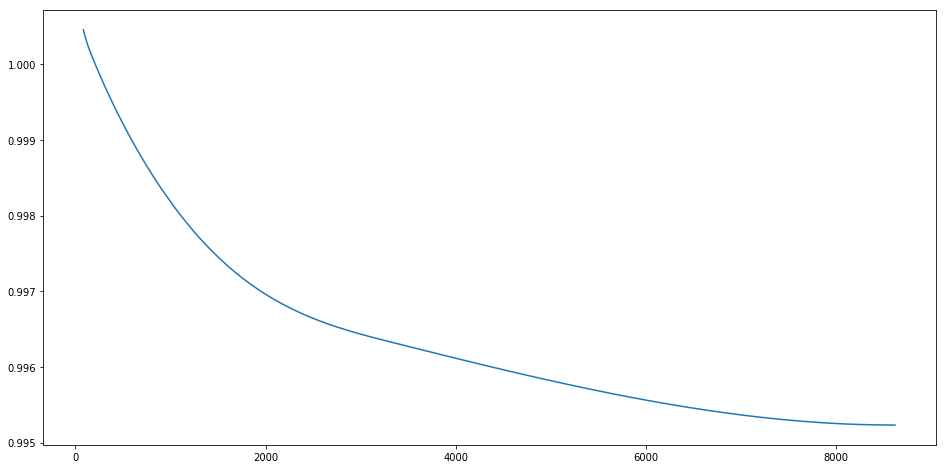

In [82]:
plt.figure(5, figsize=(16, 8))
plt.plot(X.ravel(), spline_1(X.ravel()), )

In [10]:
from scipy.interpolate import UnivariateSpline, splev, splrep
from scipy.optimize import minimize

def guess(x, y, k, s, w=None):
    """Do an ordinary spline fit to provide knots"""
    return splrep(x, y, w, k=k, s=s)

def err(c, x, y, t, k, w=None):
    """The error function to minimize"""
    diff = y - splev(x, (t, c, k))
    if w is None:
        diff = np.einsum('...i,...i', diff, diff)
    else:
        diff = np.dot(diff*diff, w)
    return np.abs(diff)

def spline_dirichlet(x, y, k=3, s=0, w=None):
    t, c0, k = guess(x, y, k, s, w=w)
    x0 = x[0] # point at which 1 is required
    con = {'type': 'eq',
           'fun': lambda c: splev(x0, (t, c, k), der=0)-1,
           }
    opt = minimize(err, c0, (x, y, t, k, w), constraints=con)
    copt = opt.x
    return UnivariateSpline._from_tck((t, copt, k))

In [87]:
y

array([1.00036042, 1.0003619 , 1.0004154 , 1.00042201, 1.0005385 ,
       1.00052097, 1.00039487, 1.00033772, 1.00041249, 1.00034285,
       1.00027396, 1.0006814 , 1.00015311, 1.00032232, 1.00023953,
       1.00022123, 1.00021465, 1.00010914, 1.00036047, 1.00014504,
       1.0000945 , 1.00024322, 1.00026005, 1.00028569, 1.00014577,
       1.00012305, 1.00002783, 1.00031358, 1.00011795, 0.99995092,
       0.99998242, 0.99990186, 0.99995239, 0.99996337, 1.00000733,
       0.99991503, 0.99987108, 0.99985423, 0.99986083, 0.999833  ,
       0.99992895, 0.99991137, 0.99972606, 0.99955766, 0.99951884,
       0.99942217, 0.99945434, 0.99928029, 0.99928962, 0.99928959,
       0.99932625, 0.99907216, 0.99912181, 0.99904357, 0.99910258,
       0.9989895 , 0.99883652, 0.99875228, 0.99865145, 0.99856921,
       0.99848141, 0.99842772, 0.99832079, 0.99821392, 0.99792768,
       0.99800713, 0.99780039, 0.99773428, 0.99753506, 0.99755093,
       0.99755238, 0.99734622, 0.99746466, 0.9972268 , 0.99714

In [78]:
sp = spline_dirichlet(X.ravel(), y, k=3, s=10)

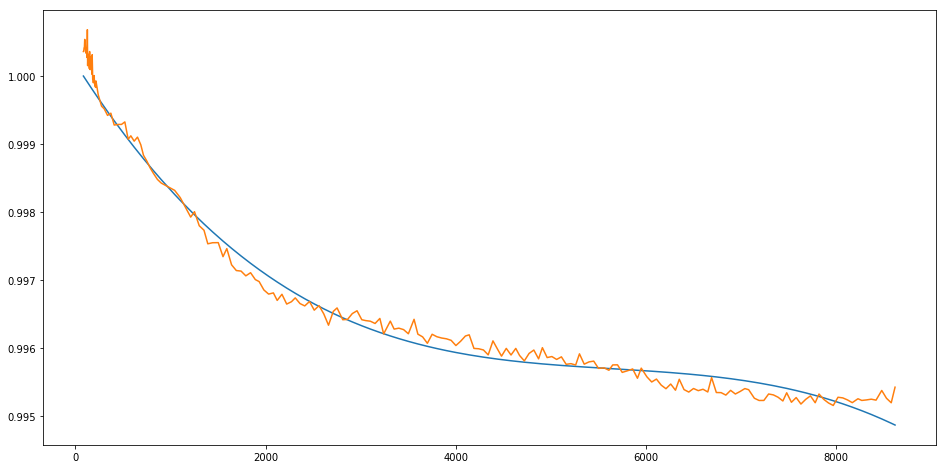

In [79]:
plt.figure(5, figsize=(16, 8))
plt.plot(X.ravel(), sp(X.ravel()), X.ravel(), y)

In [89]:
from sklearn.metrics import mean_squared_error, make_scorer
import sklearn as sk
from sklearn.model_selection import KFold

In [157]:
class SplineWithInitialOne: 
    def __init__(self, k=3, s=1e-3):
        self.k = k
        self.s = s
        
    def fit(self, x, y):
        self.sp = spline_dirichlet(x.ravel(), y, self.k, self.s)
        return self.sp
    
    def predict(self, x):
        return self.sp(x)
    
    def get_params(self, deep=True):
        return {'k' : self.k,
                's' : self.s}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [181]:
s_param = [j*10**i for i in range(-10,0) for j in range(1, 9)]


param_grid = [
    {
        's' : s_param,

    },
]

In [191]:
grid = GridSearchCV(SplineWithInitialOne(k=3),
                    cv=ThinningFolds(t=0.02),
                    n_jobs=-1,
                    scoring= make_scorer(mean_squared_error),
                    param_grid=param_grid)

In [192]:
start_time = time.time()
grid.fit(X.ravel(), y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 10.018266916275024 seconds ---


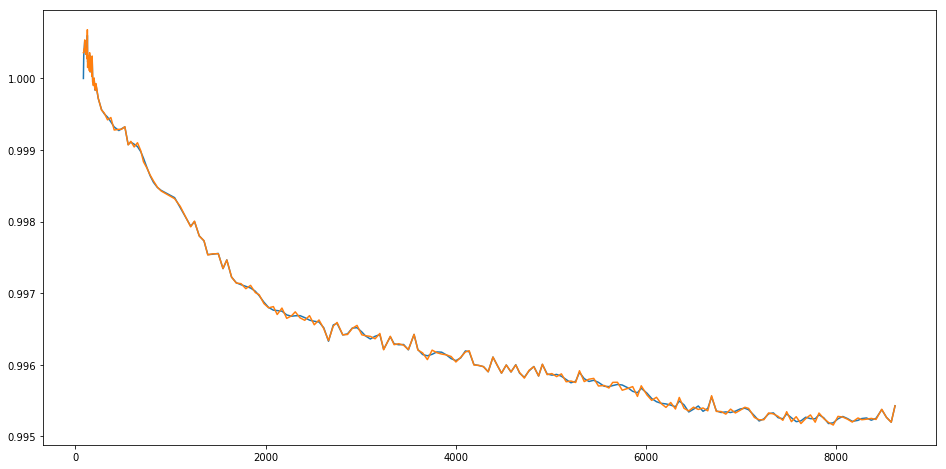

In [193]:
plt.figure(5, figsize=(16, 8))
plt.plot(X.ravel(), grid.predict(X.ravel()), X.ravel(), y)

In [102]:
grid.cv_results_

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([0.03616536, 0.04407704, 0.04146469, 0.04182494, 0.02573657,
        0.03242707, 0.026317  , 0.03245461, 0.03238726, 0.03634298,
        0.02575612, 0.02868354, 0.03248954, 0.02103794, 0.02759755,
        0.02134061, 0.01619411, 0.02236998, 0.02197564, 0.01881492,
        0.01766992, 0.01652205, 0.01985455, 0.02110457, 0.01756799,
        0.01442301, 0.00981891, 0.02207959, 0.00669801, 0.02227199,
        0.00538707, 0.0098815 , 0.00838649, 0.00666106, 0.00644195,
        0.00639403, 0.00373697, 0.00372589, 0.00368249, 0.00633454,
        0.00561059, 0.00502098, 0.00500596, 0.00803149, 0.00681806,
        0.0045191 , 0.00512397, 0.00589085, 0.006724  , 0.00494885,
        0.0052346 , 0.00463653, 0.00628448, 0.00347948, 0.00583696,
        0.00835359, 0.00595391, 0.00596905, 0.00609708, 0.00438499,
        0.0034982 , 0.00366247, 0.00650251, 0.00588262, 0.005247  ,
        0.00399542, 0.00555754, 0.00451291, 0.00356615, 0.00466204,
        0.00417805, 0.00504303,

In [142]:
from sklearn.model_selection import ShuffleSplit
y = np.array([1, 1, 1,1,1,1,1,1,1,1])
x = np.array([[1, 1, 1,1,1,1,1,1,1,1], [1, 1, 1,1,1,1,1,1,1,1]])

In [143]:
rs = ShuffleSplit(n_splits=5, test_size=.8, random_state=0)
for i in rs.split(x, y):
    print(i)

ValueError: Found input variables with inconsistent numbers of samples: [2, 10]

In [177]:
class ThinningFolds:
    
    def __init__(self, t=0.1):
        self.t = t
    
    def split(self, x, *params):
        l = len(x)
        n = int(1/self.t)
        for i in range(n):
            train = np.arange(i, l, n)
            test = np.array([j for j in range(l) if j % n != i])
            yield (train, test)
    
    def get_n_splits(self, x, *params):
        n = int(1/self.t)
        return n
        

In [113]:
a = np.array([1,2,3,4,5,6,7,8,9,10])
a[::2]

array([1, 3, 5, 7, 9])

In [179]:
cv=ThinningFolds(t=0.1)

In [174]:
for i in cv.split(X):
    print(i)

(array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210]), array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  31,  32,  33,  34,  35,  36,  37,  38,  39,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  61,  62,  63,  64,  65,  66,  67,  68,  69,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  91,  92,  93,  94,  95,  96,  97,  98,  99, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173,
       17

In [180]:
cv.get_n_splits(X)

10